## Cours sur l'entrainement de deux agents avec de l'apprentisage par renforcement dans un environement competitif.

In [1]:
import copy
import tempfile

import torch

from matplotlib import pyplot as plt
from tensordict import TensorDictBase

from tensordict.nn import TensorDictModule, TensorDictSequential
from torch import multiprocessing

from torchrl.collectors import SyncDataCollector
from torchrl.data import LazyMemmapStorage, RandomSampler, ReplayBuffer

from torchrl.envs import (
    check_env_specs,
    ExplorationType,
    PettingZooEnv,
    RewardSum,
    set_exploration_type,
    TransformedEnv,
    VmasEnv,
)

from torchrl.modules import (
    AdditiveGaussianModule,
    MultiAgentMLP,
    ProbabilisticActor,
    TanhDelta,
)

from torchrl.objectives import DDPGLoss, SoftUpdate, ValueEstimators
from torchrl.record import CSVLogger, PixelRenderTransform, VideoRecorder
from tqdm import tqdm

c:\Users\FX643778\AppData\Local\anaconda3\envs\pythorch_class\lib\site-packages\torchrl\data\replay_buffers\samplers.py:36: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. This is likely due to a discrepancy between your package version and the PyTorch version. Make sure both are compatible. Usually, torchrl majors follow the pytorch majors within a few days around the release. For instance, TorchRL 0.5 requires PyTorch 2.4.0, and TorchRL 0.6 requires PyTorch 2.5.0.
  warnings.warn(EXTENSION_WARNING)


In [2]:
# Seed
seed = 0
torch.manual_seed(seed)

# Devices
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)

# Sampling
frames_per_batch = 1_000  # Number of team frames collected per sampling iteration
n_iters = 50  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters

# We will stop training the evaders after this many iterations,
# should be 0 <= iteration_when_stop_training_evaders <= n_iters
iteration_when_stop_training_evaders = n_iters // 2

# Replay buffer
memory_size = 1_000_000  # The replay buffer of each group can store this many frames

# Training
n_optimiser_steps = 100  # Number of optimization steps per training iteration
train_batch_size = 128  # Number of frames trained in each optimiser step
lr = 3e-4  # Learning rate
max_grad_norm = 1.0  # Maximum norm for the gradients

# DDPG
gamma = 0.99  # Discount factor
polyak_tau = 0.005  # Tau for the soft-update of the target network

In [5]:
simple_push_v3.parallel_env??

Object `simple_push_v3.parallel_env` not found.


In [3]:
max_steps = 100  # Environment steps before done

n_chasers = 2
n_evaders = 1
n_obstacles = 2

use_vmas = False  # Set this to True for a great performance speedup

if not use_vmas:
    base_env = PettingZooEnv(
        task="simple_tag_v3",
        parallel=True,  # Use the Parallel version
        seed=seed,
        # Scenario specific
        continuous_actions=True,
        num_good=n_evaders,
        num_adversaries=n_chasers,
        num_obstacles=n_obstacles,
        max_cycles=max_steps,
    )
else:
    num_vmas_envs = (
        frames_per_batch // max_steps
    )  # Number of vectorized environments. frames_per_batch collection will be divided among these environments
    base_env = VmasEnv(
        scenario="simple_tag",
        num_envs=num_vmas_envs,
        continuous_actions=True,
        max_steps=max_steps,
        device=device,
        seed=seed,
        # Scenario specific
        num_good_agents=n_evaders,
        num_adversaries=n_chasers,
        num_landmarks=n_obstacles,
    )

c:\Users\FX643778\AppData\Local\anaconda3\envs\pythorch_class\lib\site-packages\torchrl\envs\libs\pettingzoo.py:1019: UserWarning: PettingZoo failed to load all modules with error message No module named 'multi_agent_ale_py', trying to load individual modules.
  warnings.warn(
c:\Users\FX643778\AppData\Local\anaconda3\envs\pythorch_class\lib\site-packages\torchrl\envs\libs\pettingzoo.py:52: UserWarning: SISL environments failed to load with error message No module named 'Box2D'.
  warnings.warn(f"SISL environments failed to load with error message {err}.")
c:\Users\FX643778\AppData\Local\anaconda3\envs\pythorch_class\lib\site-packages\torchrl\envs\libs\pettingzoo.py:58: UserWarning: Classic environments failed to load with error message No module named 'chess'.
  warnings.warn(f"Classic environments failed to load with error message {err}.")
c:\Users\FX643778\AppData\Local\anaconda3\envs\pythorch_class\lib\site-packages\torchrl\envs\libs\pettingzoo.py:64: UserWarning: Atari environment

In [4]:
print(f"group_map: {base_env.group_map}")

group_map: {'adversary': ['adversary_0', 'adversary_1'], 'agent': ['agent_0']}


In [5]:
print("action_spec:", base_env.full_action_spec)
print("reward_spec:", base_env.full_reward_spec)
print("done_spec:", base_env.full_done_spec)
print("observation_spec:", base_env.observation_spec)

action_spec: Composite(
    adversary: Composite(
        action: BoundedContinuous(
            shape=torch.Size([2, 5]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([2, 5]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([2, 5]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32,
            domain=continuous),
        device=None,
        shape=torch.Size([2]),
        data_cls=None),
    agent: Composite(
        action: BoundedContinuous(
            shape=torch.Size([1, 5]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([1, 5]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([1, 5]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32,
            domain=continuous),
        device=None,
        shape=torch.S

In [6]:
print("action_keys:", base_env.action_keys)
print("reward_keys:", base_env.reward_keys)
print("done_keys:", base_env.done_keys)

action_keys: [('adversary', 'action'), ('agent', 'action')]
reward_keys: [('adversary', 'reward'), ('agent', 'reward')]
done_keys: ['done', 'terminated', 'truncated', ('adversary', 'done'), ('adversary', 'terminated'), ('adversary', 'truncated'), ('agent', 'done'), ('agent', 'terminated'), ('agent', 'truncated')]


In [7]:
env = TransformedEnv(
    base_env,
    RewardSum(
        in_keys=base_env.reward_keys,
        reset_keys=["_reset"] * len(base_env.group_map.keys()),
    ),
)

In [8]:
n_rollout_steps = 5
rollout = env.rollout(n_rollout_steps)
print(f"rollout of {n_rollout_steps} steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of 5 steps: TensorDict(
    fields={
        adversary: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([5, 2, 5]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([5, 2, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([5, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                observation: Tensor(shape=torch.Size([5, 2, 14]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([5, 2, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([5, 2, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([5, 2]),
            device=None,
            is_shared=False),
        agent: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([5, 1, 5]), device=cpu, dtype=to

In [9]:
policy_modules = {}
for group, agents in env.group_map.items():
    share_parameters_policy = True  # Can change this based on the group

    policy_net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec[group, "observation"].shape[
            -1
        ],  # n_obs_per_agent
        n_agent_outputs=env.full_action_spec[group, "action"].shape[
            -1
        ],  # n_actions_per_agents
        n_agents=len(agents),  # Number of agents in the group
        centralised=False,  # the policies are decentralised (i.e., each agent will act from its local observation)
        share_params=share_parameters_policy,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    )

    # Wrap the neural network in a :class:`~tensordict.nn.TensorDictModule`.
    # This is simply a module that will read the ``in_keys`` from a tensordict, feed them to the
    # neural networks, and write the
    # outputs in-place at the ``out_keys``.

    policy_module = TensorDictModule(
        policy_net,
        in_keys=[(group, "observation")],
        out_keys=[(group, "param")],
    )  # We just name the input and output that the network will read and write to the input tensordict
    policy_modules[group] = policy_module

In [23]:
print(env.full_action_spec_unbatched)

Composite(
    adversary: Composite(
        action: BoundedContinuous(
            shape=torch.Size([2, 5]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([2, 5]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([2, 5]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32,
            domain=continuous),
        device=cpu,
        shape=torch.Size([2]),
        data_cls=None),
    agent: Composite(
        action: BoundedContinuous(
            shape=torch.Size([1, 5]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([1, 5]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([1, 5]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32,
            domain=continuous),
        device=cpu,
        shape=torch.Size([1]),
     

In [10]:
policies = {}
for group, _agents in env.group_map.items():
    policy = ProbabilisticActor(
        module=policy_modules[group],
        spec=env.full_action_spec[group, "action"],
        in_keys=[(group, "param")],
        out_keys=[(group, "action")],
        distribution_class=TanhDelta,
        distribution_kwargs={
            "low": env.full_action_spec_unbatched[group, "action"].space.low,
            "high": env.full_action_spec_unbatched[group, "action"].space.high,
        },
        return_log_prob=False,
    )
    policies[group] = policy

In [11]:
exploration_policies = {}
for group, _agents in env.group_map.items():
    exploration_policy = TensorDictSequential(
        policies[group],
        AdditiveGaussianModule(
            spec=policies[group].spec,
            annealing_num_steps=total_frames
            // 2,  # Number of frames after which sigma is sigma_end
            action_key=(group, "action"),
            sigma_init=0.9,  # Initial value of the sigma
            sigma_end=0.1,  # Final value of the sigma
        ),
    )
    exploration_policies[group] = exploration_policy

In [12]:
critics = {}
for group, agents in env.group_map.items():
    share_parameters_critic = True  # Can change for each group
    MADDPG = True  # IDDPG if False, can change for each group

    # This module applies the lambda function: reading the action and observation entries for the group
    # and concatenating them in a new ``(group, "obs_action")`` entry
    cat_module = TensorDictModule(
        lambda obs, action: torch.cat([obs, action], dim=-1),
        in_keys=[(group, "observation"), (group, "action")],
        out_keys=[(group, "obs_action")],
    )

    critic_module = TensorDictModule(
        module=MultiAgentMLP(
            n_agent_inputs=env.observation_spec[group, "observation"].shape[-1]
            + env.full_action_spec[group, "action"].shape[-1],
            n_agent_outputs=1,  # 1 value per agent
            n_agents=len(agents),
            centralised=MADDPG,
            share_params=share_parameters_critic,
            device=device,
            depth=2,
            num_cells=256,
            activation_class=torch.nn.Tanh,
        ),
        in_keys=[(group, "obs_action")],  # Read ``(group, "obs_action")``
        out_keys=[
            (group, "state_action_value")
        ],  # Write ``(group, "state_action_value")``
    )

    critics[group] = TensorDictSequential(
        cat_module, critic_module
    )  # Run them in sequence

In [13]:
reset_td = env.reset()
for group, _agents in env.group_map.items():
    print(
        f"Running value and policy for group '{group}':",
        critics[group](policies[group](reset_td)),
    )

Running value and policy for group 'adversary': TensorDict(
    fields={
        adversary: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([2, 5]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                obs_action: Tensor(shape=torch.Size([2, 19]), device=cpu, dtype=torch.float32, is_shared=False),
                observation: Tensor(shape=torch.Size([2, 14]), device=cpu, dtype=torch.float32, is_shared=False),
                param: Tensor(shape=torch.Size([2, 5]), device=cpu, dtype=torch.float32, is_shared=False),
                state_action_value: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.bool, is_

In [14]:
# Put exploration policies from each group in a sequence
agents_exploration_policy = TensorDictSequential(*exploration_policies.values())

collector = SyncDataCollector(
    env,
    agents_exploration_policy,
    device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

In [15]:
replay_buffers = {}
scratch_dirs = []
for group, _agents in env.group_map.items():
    scratch_dir = tempfile.TemporaryDirectory().name
    scratch_dirs.append(scratch_dir)
    replay_buffer = ReplayBuffer(
        storage=LazyMemmapStorage(
            memory_size,
            scratch_dir=scratch_dir,
        ),  # We will store up to memory_size multi-agent transitions
        sampler=RandomSampler(),
        batch_size=train_batch_size,  # We will sample batches of this size
    )
    if device.type != "cpu":
        replay_buffer.append_transform(lambda x: x.to(device))
    replay_buffers[group] = replay_buffer

In [16]:
losses = {}
for group, _agents in env.group_map.items():
    loss_module = DDPGLoss(
        actor_network=policies[group],  # Use the non-explorative policies
        value_network=critics[group],
        delay_value=True,  # Whether to use a target network for the value
        loss_function="l2",
    )
    loss_module.set_keys(
        state_action_value=(group, "state_action_value"),
        reward=(group, "reward"),
        done=(group, "done"),
        terminated=(group, "terminated"),
    )
    loss_module.make_value_estimator(ValueEstimators.TD0, gamma=gamma)

    losses[group] = loss_module

target_updaters = {
    group: SoftUpdate(loss, tau=polyak_tau) for group, loss in losses.items()
}

optimisers = {
    group: {
        "loss_actor": torch.optim.Adam(
            loss.actor_network_params.flatten_keys().values(), lr=lr
        ),
        "loss_value": torch.optim.Adam(
            loss.value_network_params.flatten_keys().values(), lr=lr
        ),
    }
    for group, loss in losses.items()
}

In [17]:
def process_batch(batch: TensorDictBase) -> TensorDictBase:
    """
    If the `(group, "terminated")` and `(group, "done")` keys are not present, create them by expanding
    `"terminated"` and `"done"`.
    This is needed to present them with the same shape as the reward to the loss.
    """
    for group in env.group_map.keys():
        keys = list(batch.keys(True, True))
        group_shape = batch.get_item_shape(group)
        nested_done_key = ("next", group, "done")
        nested_terminated_key = ("next", group, "terminated")
        if nested_done_key not in keys:
            batch.set(
                nested_done_key,
                batch.get(("next", "done")).unsqueeze(-1).expand((*group_shape, 1)),
            )
        if nested_terminated_key not in keys:
            batch.set(
                nested_terminated_key,
                batch.get(("next", "terminated"))
                .unsqueeze(-1)
                .expand((*group_shape, 1)),
            )
    return batch

In [18]:
pbar = tqdm(
    total=n_iters,
    desc=", ".join(
        [f"episode_reward_mean_{group} = 0" for group in env.group_map.keys()]
    ),
)
episode_reward_mean_map = {group: [] for group in env.group_map.keys()}
train_group_map = copy.deepcopy(env.group_map)

# Training/collection iterations
for iteration, batch in enumerate(collector):
    current_frames = batch.numel()
    batch = process_batch(batch)  # Util to expand done keys if needed
    # Loop over groups
    for group in train_group_map.keys():
        group_batch = batch.exclude(
            *[
                key
                for _group in env.group_map.keys()
                if _group != group
                for key in [_group, ("next", _group)]
            ]
        )  # Exclude data from other groups
        group_batch = group_batch.reshape(
            -1
        )  # This just affects the leading dimensions in batch_size of the tensordict
        replay_buffers[group].extend(group_batch)

        for _ in range(n_optimiser_steps):
            subdata = replay_buffers[group].sample()
            loss_vals = losses[group](subdata)

            for loss_name in ["loss_actor", "loss_value"]:
                loss = loss_vals[loss_name]
                optimiser = optimisers[group][loss_name]

                loss.backward()

                # Optional
                params = optimiser.param_groups[0]["params"]
                torch.nn.utils.clip_grad_norm_(params, max_grad_norm)

                optimiser.step()
                optimiser.zero_grad()

            # Soft-update the target network
            target_updaters[group].step()

        # Exploration sigma anneal update
        exploration_policies[group][-1].step(current_frames)

    # Stop training a certain group when a condition is met (e.g., number of training iterations)
    if iteration == iteration_when_stop_training_evaders:
        del train_group_map["agent"]

    # Logging
    for group in env.group_map.keys():
        episode_reward_mean = (
            batch.get(("next", group, "episode_reward"))[
                batch.get(("next", group, "done"))
            ]
            .mean()
            .item()
        )
        episode_reward_mean_map[group].append(episode_reward_mean)

    pbar.set_description(
        ", ".join(
            [
                f"episode_reward_mean_{group} = {episode_reward_mean_map[group][-1]}"
                for group in env.group_map.keys()
            ]
        ),
        refresh=False,
    )
    pbar.update()

episode_reward_mean_adversary = 0.0, episode_reward_mean_agent = -241.2705841064453: 100%|██████████| 10/10 [01:15<00:00,  6.83s/it] 

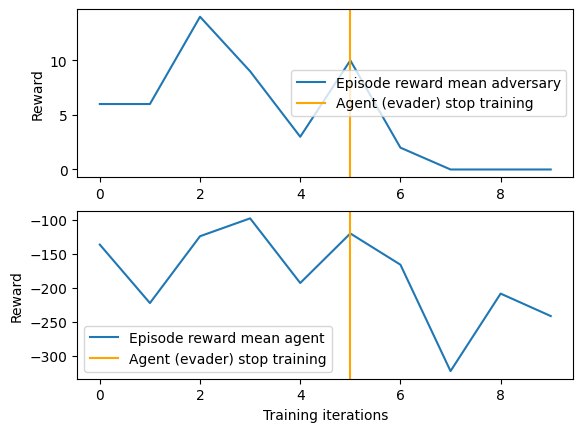

In [19]:
fig, axs = plt.subplots(2, 1)
for i, group in enumerate(env.group_map.keys()):
    axs[i].plot(episode_reward_mean_map[group], label=f"Episode reward mean {group}")
    axs[i].set_ylabel("Reward")
    axs[i].axvline(
        x=iteration_when_stop_training_evaders,
        label="Agent (evader) stop training",
        color="orange",
    )
    axs[i].legend()
axs[-1].set_xlabel("Training iterations")
plt.show()

In [20]:
if use_vmas and not is_sphinx:
    # Replace tmpdir with any desired path where the video should be saved
    with tempfile.TemporaryDirectory() as tmpdir:
        video_logger = CSVLogger("vmas_logs", tmpdir, video_format="mp4")
        print("Creating rendering env")
        env_with_render = TransformedEnv(env.base_env, env.transform.clone())
        env_with_render = env_with_render.append_transform(
            PixelRenderTransform(
                out_keys=["pixels"],
                # the np.ndarray has a negative stride and needs to be copied before being cast to a tensor
                preproc=lambda x: x.copy(),
                as_non_tensor=True,
                # asking for array rather than on-screen rendering
                mode="rgb_array",
            )
        )
        env_with_render = env_with_render.append_transform(
            VideoRecorder(logger=video_logger, tag="vmas_rendered")
        )
        with set_exploration_type(ExplorationType.DETERMINISTIC):
            print("Rendering rollout...")
            env_with_render.rollout(100, policy=agents_exploration_policy)
        print("Saving the video...")
        env_with_render.transform.dump()
        print("Saved! Saved directory tree:")
        video_logger.print_log_dir()

In [4]:
from pettingzoo.mpe import simple_reference_v3

env = simple_reference_v3.env(render_mode="human")
env.reset(seed=42)

for agent in env.agent_iter():
    observation, reward, termination, truncation, info = env.last()

    if termination or truncation:
        action = None
    else:
        # this is where you would insert your policy
        action = env.action_space(agent).sample()

    env.step(action)
env.close()
